# DataChallenge

## Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

## Parameters, Hyperparameters, Seed

In [2]:
seed = 42 # We fix the seed for reproducibility
train = 1
drop = 1
n_splits = 3
n_jobs = -1

## Metric

In [3]:
def metric(y_true, y_pred):
    f = 1 + 0.2 * (y_true >= 0.5)              # pondère les cas où la vraie valeur est positive
    diff = (y_true - y_pred) ** 2              # erreur quadratique
    weighted = f * diff                        # pondération appliquée
    errors = np.mean(weighted, axis=1)         # moyenne par ligne
    final_error = np.sqrt(np.mean(errors))     # racine de la moyenne
    return final_error

In [4]:
def modif_predictions(y_pred, alpha=1.1, threshold=0.48, floor=0.5):
    y_pred = np.clip(y_pred, 0, 1)
    y_pred *= alpha
    y_pred = np.where(y_pred <= threshold, y_pred, np.maximum(y_pred, floor))
    return y_pred

## Data Collection

In [5]:
X = pd.read_csv("x_train_T9QMMVq.csv")
print(f"Dimension of the dataset: {X.shape}")
y = pd.read_csv("y_train_R0MqWmu.csv")
print(f"Dimension of the response vector: {y.shape}")

Dimension of the dataset: (202933, 14)
Dimension of the response vector: (202933, 24)


### Train Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


## Data Processing

### X_train

In [7]:
print(X_train.shape)
print(X_train.head())

(162346, 14)
            ID  Humidity       M12       M13       M14       M15        M4  \
83977    83977  0.000348  0.313952  0.318127  0.239639  0.159481  1.924629   
73286    73286  0.000307 -0.231707 -0.171588 -0.086420 -0.024423  0.864830   
29410    29410  0.000380 -1.487934 -1.161179 -0.680230 -0.180912  0.278883   
115904  115904  0.000372  1.201727  0.663022  0.307463  0.134050 -0.357562   
197669  197669  0.000398  0.301020  0.324043  0.266483  0.247296  0.031978   

              M5        M6        M7         R        S1        S2        S3  
83977   0.586991  0.161986  0.083498  1.083037  0.591780  0.974189  0.995566  
73286   0.362590  0.125247  0.031938  1.092785  0.982357  0.995121  0.991582  
29410   0.120794  0.076818  0.091848  0.980139  0.824927  0.970992  0.995046  
115904 -0.090536 -0.004938  0.004580  1.133194  0.925951  1.073937  0.989558  
197669  0.060545  0.135587  0.161169  1.245051  0.953699  0.966491  0.987111  


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162346 entries, 83977 to 121958
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        162346 non-null  int64  
 1   Humidity  162346 non-null  float64
 2   M12       162346 non-null  float64
 3   M13       162346 non-null  float64
 4   M14       162346 non-null  float64
 5   M15       162346 non-null  float64
 6   M4        162346 non-null  float64
 7   M5        162346 non-null  float64
 8   M6        162346 non-null  float64
 9   M7        162346 non-null  float64
 10  R         162346 non-null  float64
 11  S1        162346 non-null  float64
 12  S2        162346 non-null  float64
 13  S3        162346 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 18.6 MB


In [9]:
X_train.describe()

,ID,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
count,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000,162346.000000
mean,101408.943694,0.225950,-0.300611,-0.250860,-0.157227,-0.049351,0.892779,0.456369,0.175989,0.081107,1.185020,0.859572,1.016162,1.000687
std,58566.592738,0.335702,1.426455,1.251293,0.852290,0.363430,2.438595,1.586672,0.820778,0.395636,1.788856,0.302135,1.209245,0.023486
min,0.000000,0.000305,-13.021540,-11.844691,-9.117980,-4.165993,-2.831466,-0.790972,-0.224497,-0.147250,0.023324,0.025957,0.151214,0.710207
25%,50735.500000,0.000379,-0.288268,-0.179096,-0.087138,-0.032475,-0.050125,-0.006568,0.001832,0.001548,0.973675,0.773412,0.959109,0.996275
50%,101477.500000,0.090098,-0.000644,0.018674,0.019633,0.012752,0.158831,0.067587,0.035869,0.025857,1.014379,0.931223,0.988131,0.999959
75%,152026.750000,0.330161,0.209259,0.176865,0.120979,0.066618,0.657394,0.260514,0.120237,0.077152,1.120219,0.999391,1.000258,1.008607
max,202931.000000,0.958255,2.545019,2.864641,2.004906,0.842932,28.245698,28.710670,20.508550,10.714200,48.026927,6.626481,55.702963,1.057846


In [10]:
X_train.nunique()

ID          162346
Humidity     66630
M12          14984
M13          12181
M14           8611
M15           4712
M4           22234
M5           13943
M6            6771
M7            3811
R           125153
S1           67998
S2           44482
S3           17319
dtype: int64

There are many duplicates.

In [11]:
X_train.isnull().sum()

ID          0
Humidity    0
M12         0
M13         0
M14         0
M15         0
M4          0
M5          0
M6          0
M7          0
R           0
S1          0
S2          0
S3          0
dtype: int64

In [12]:
# Find out if there is at least one missing value 
null = X_train.isnull().values
if null.any() >=1 :
    count = len(X_train[X_train.isnull().any(axis=1)])
    print(f"Number of rows with at least one missing value: {count}")
    proportion = count / len(X_train) * 100
    print(f"Proportion of rows with missing values in the dataset: {np.round(proportion,2)}")
else:
    print("There is no missing value.")

There is no missing value.


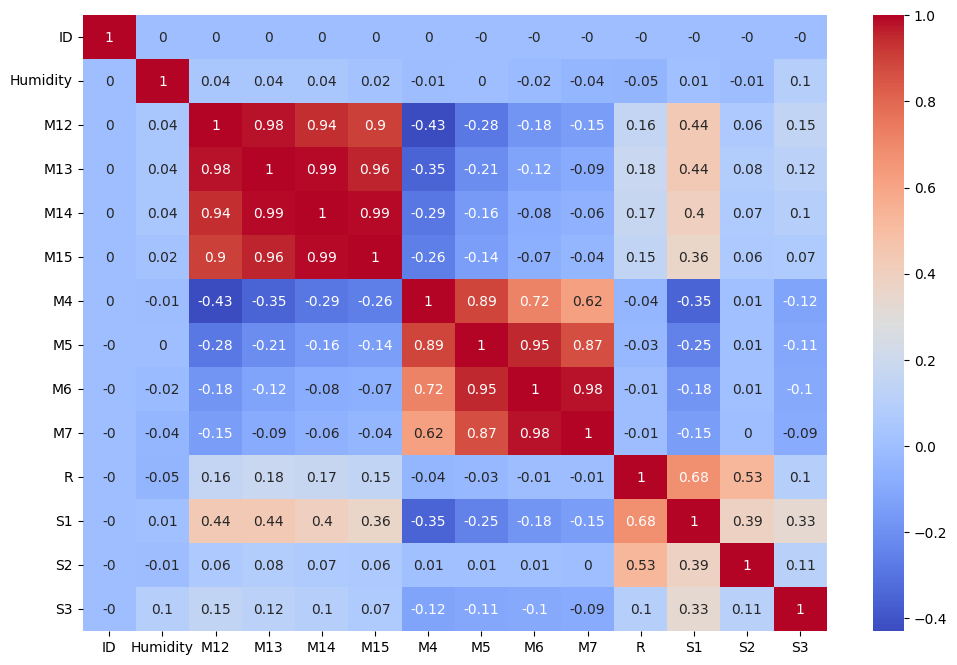

In [13]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr().round(2), cmap="coolwarm", annot=True, annot_kws={"size":10})
plt.show()

There are many highly correlated variables.

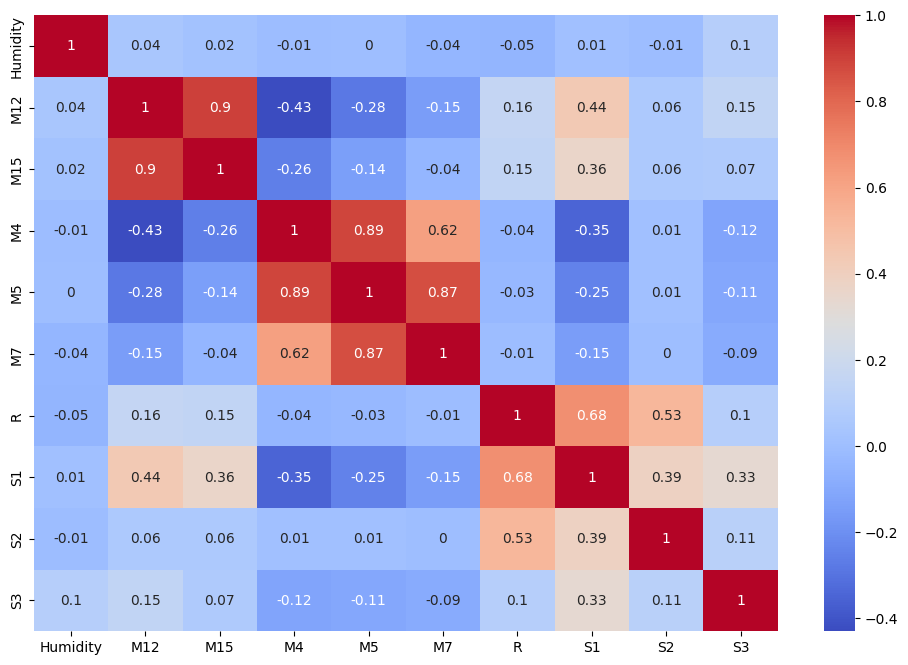

In [14]:
data = X_train.copy()
remove_col = ["M13","M14","M6"]
data = data.drop(["ID"] + remove_col, axis = 1)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr().round(2), cmap="coolwarm", annot=True, annot_kws={"size":10})
plt.show()

### y_train

In [15]:
print(y_train.shape)
print(y_train.head())

(162346, 24)
            ID       c01       c02       c03       c04  c05  c06       c07  \
83977    83977  0.765198  0.000000  0.765198  0.765198  0.0  0.0  0.000000   
73286    73286  0.000000  0.000000  0.042135  0.042135  0.0  0.0  0.000000   
29410    29410  0.450736  0.000000  0.450736  0.450736  0.0  0.0  0.000000   
115904  115904  0.000000  0.400324  0.400324  0.400324  0.0  0.0  0.400324   
197669  197669  0.237896  0.000000  0.237896  0.237896  0.0  0.0  0.000000   

        c08       c09  ...       c14  c15  c16  c17       c18  c19       c20  \
83977   0.0  0.000000  ...  0.765198  0.0  0.0  0.0  0.000000  0.0  0.000000   
73286   0.0  0.042135  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
29410   0.0  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
115904  0.0  0.000000  ...  0.000000  0.0  0.0  0.0  0.000000  0.0  0.400324   
197669  0.0  0.000000  ...  0.000000  0.0  0.0  0.0  0.237896  0.0  0.000000   

        c21       c22  c23  
83977   

In [16]:
y_train.nunique()

ID     162346
c01     76951
c02     23431
c03    122510
c04    122510
c05      7960
c06      7960
c07     23431
c08      1610
c09      4155
c10     21940
c11     19058
c12     30975
c13     22616
c14     29823
c15         1
c16       898
c17      7048
c18     31149
c19      3376
c20     23431
c21      7960
c22    122510
c23      7875
dtype: int64

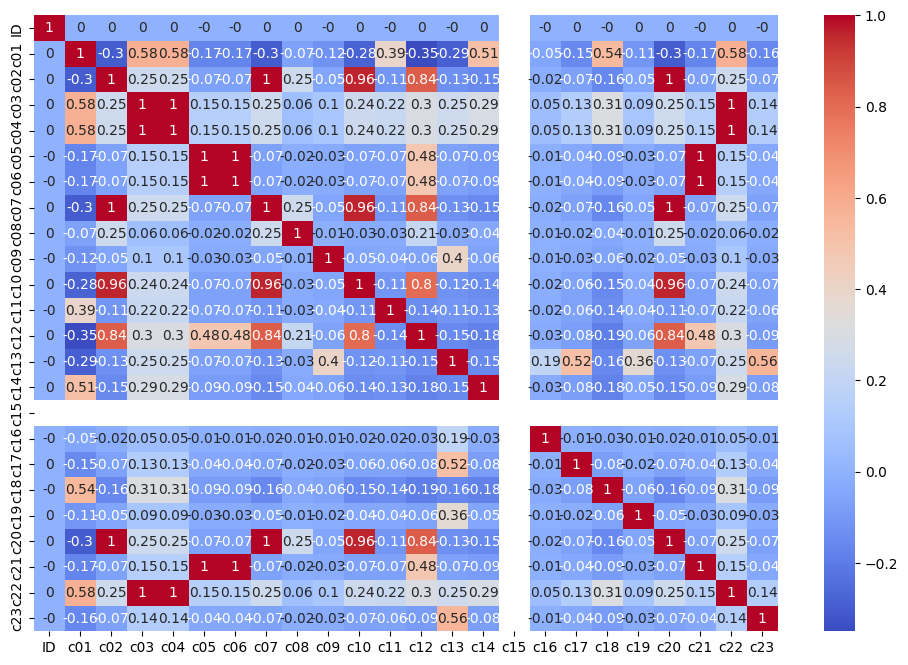

In [17]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(y_train.corr().round(2), cmap="coolwarm", annot=True, annot_kws={"size":10})
plt.show()

c15 always has the same value.

In [18]:
print((y_train["c15"] > 0).sum())

0


c15 is still null so no need to predict it.

Let’s look at c03, c04 and c22.

In [19]:
print((y_train["c03"] != y_train["c04"]).sum())
print((y_train["c03"] != y_train["c22"]).sum())

0
0


c03, c04 and c22 are always equal, so we can keep and predict only one of them.

Let’s look at c05, c06 and c21.

In [20]:
print((y_train["c05"] != y_train["c06"]).sum())
print((y_train["c05"] != y_train["c21"]).sum())

0
0


c05, c06 and c21 are always equal, so we can keep and predict only one of them.

Let’s look at c02, c07 and c20.

In [21]:
print((y_train["c02"] != y_train["c07"]).sum())
print((y_train["c02"] != y_train["c20"]).sum())

0
0


c02, c07 and c20 are always equal, so we can keep and predict only one of them.

In [22]:
# We remove the columns that can be determined without model
remove_target = ["c04","c06","c07","c15","c20","c21","c22"]
y_train_reduced = y_train.drop(remove_target, axis=1)
# We set "ID" as index
y_train_reduced.set_index("ID", inplace=True)
print(y_train_reduced.shape)

(162346, 16)


In [23]:
y_train.isnull().sum()

ID     0
c01    0
c02    0
c03    0
c04    0
c05    0
c06    0
c07    0
c08    0
c09    0
c10    0
c11    0
c12    0
c13    0
c14    0
c15    0
c16    0
c17    0
c18    0
c19    0
c20    0
c21    0
c22    0
c23    0
dtype: int64

In [24]:
# Find out if there is at least one missing value 
null = y_train.isnull().values
if null.any() >=1 :
    count = len(y_train[y_train.isnull().any(axis=1)])
    print(f"Number of rows with at least one missing value: {count}")
    proportion = count / len(y_train) * 100
    print(f"Proportion of rows with missing values in the dataset: {np.round(proportion,2)}")
else:
    print("There is no missing value.")

There is no missing value.


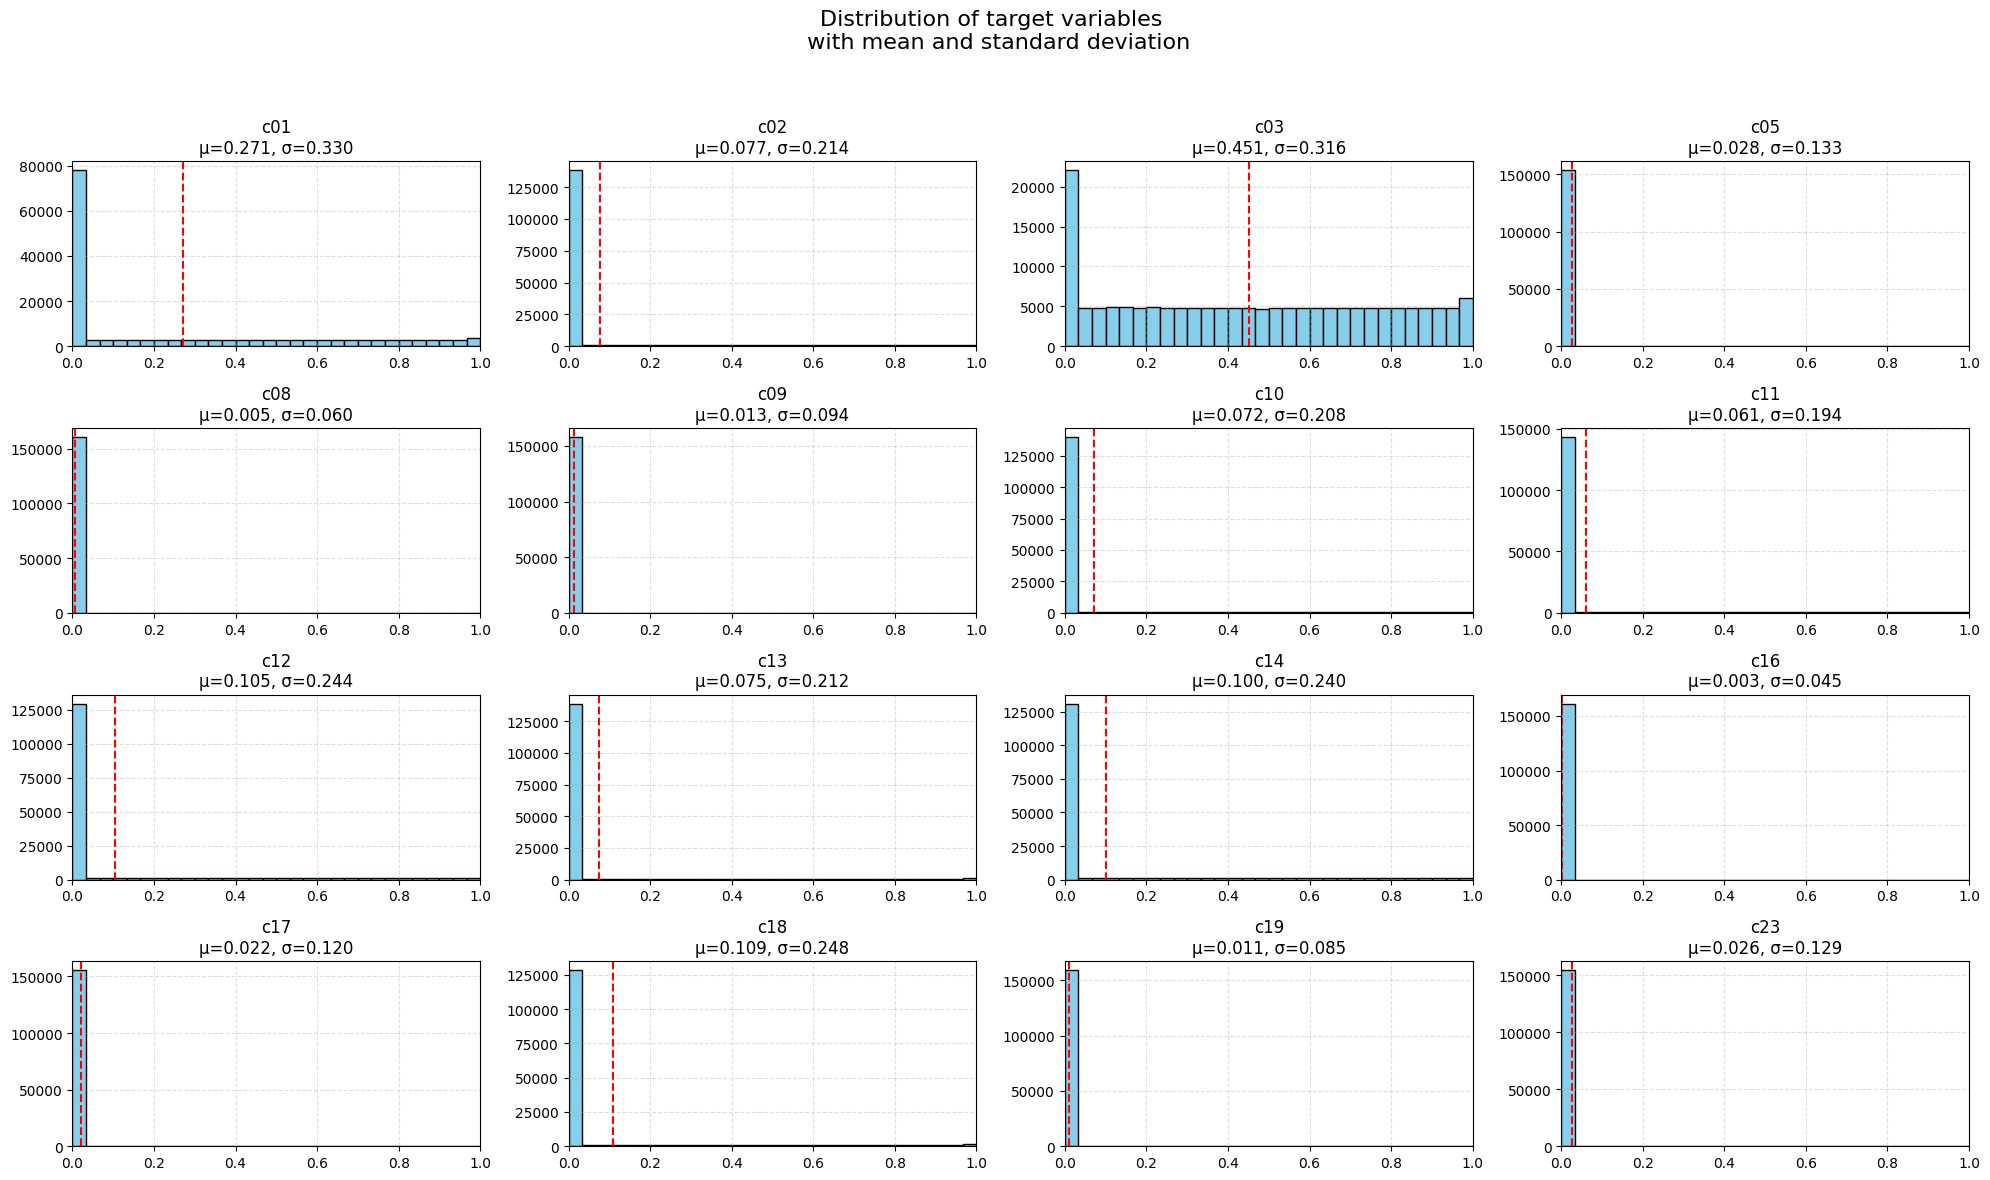

In [25]:
# Creating a sub-graph grid
fig, axes = plt.subplots(4, 4, figsize=(20, 12))
axes = axes.ravel()

# Loop on each target variable
for i, col in enumerate(y_train_reduced.columns):
    data = y_train_reduced[col].dropna()
    
    mean_val = data.mean()
    std_val = data.std()
    
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label='Moyenne')
    
    axes[i].set_title(f"{col}\nμ={mean_val:.3f}, σ={std_val:.3f}")
    axes[i].set_xlim(0, 1)  # useful because these are probabilities
    axes[i].grid(True, linestyle='--', alpha=0.4)

# If there are less than 16 variables, remove the empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of target variables \n with mean and standard deviation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Certaines variables devraient être traitées différemment des autres. En particulier, les prédictions des variables cibles ayant que des petites valeurs n'ont pas besoin de la même modification que celles ayant des valeurs proches de 0.5,...

### Study of X_TEST

In [26]:
X_TEST = pd.read_csv("x_test_9F13O5s.csv", sep=",")
print(X_TEST.shape)
print(X_TEST.head())


(134673, 14)
       ID  Humidity       M12       M13       M14       M15        M4  \
0  202933  0.869916  0.021914 -0.015737  0.009041  0.015662 -0.139344   
1  202934  0.904594 -0.100771 -0.040901  0.006137  0.013496  0.843534   
2  202935  0.688853  0.703585  1.029723  0.785505  0.293766 -0.536002   
3  202936  0.392112  0.648665  0.628007  0.416822  0.065360 -0.309533   
4  202937  0.618233  0.155158  0.285085  0.081453  0.031029 -0.801587   

         M5        M6        M7         R        S1        S2        S3  
0 -0.041396 -0.006051  0.001638  1.008217  1.000922  1.003093  0.998643  
1  0.501194  0.134963  0.024947  1.010621  0.987593  1.003104  1.009033  
2 -0.166262 -0.029509 -0.015855  1.075560  1.015945  1.038617  1.067383  
3 -0.398324 -0.269763 -0.269454  1.160165  1.084636  1.011883  1.008619  
4 -0.709802 -0.279257 -0.089210  1.051850  1.120134  1.003001  1.007571  


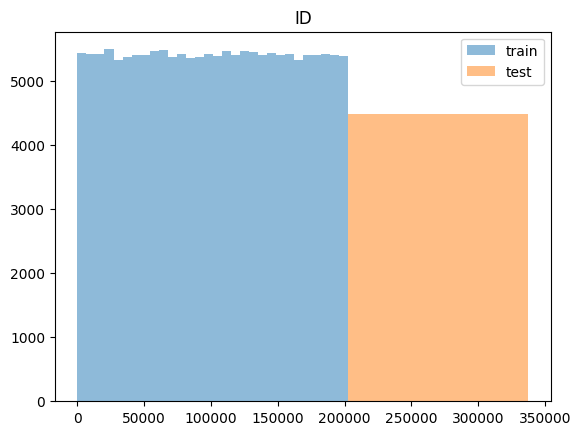

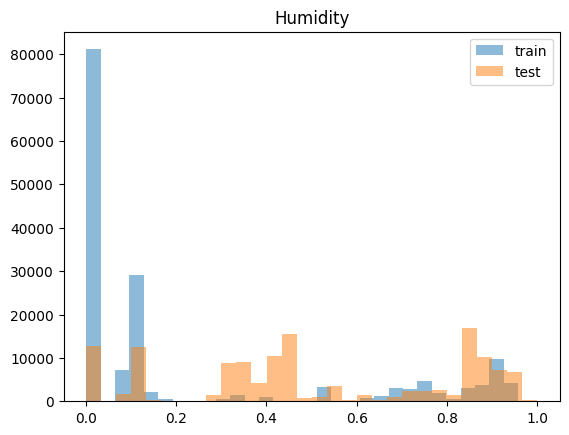

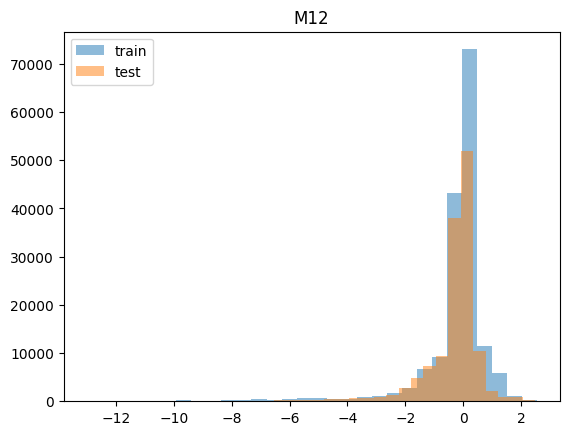

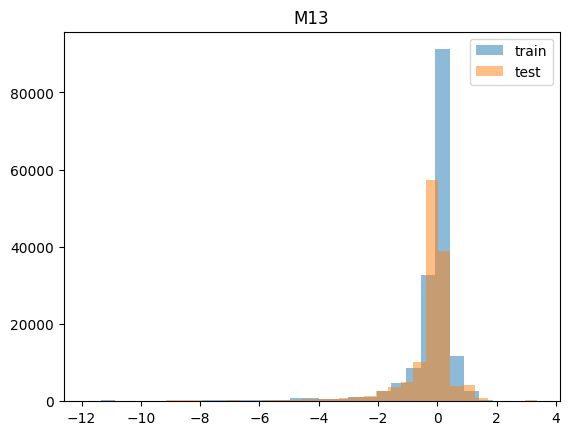

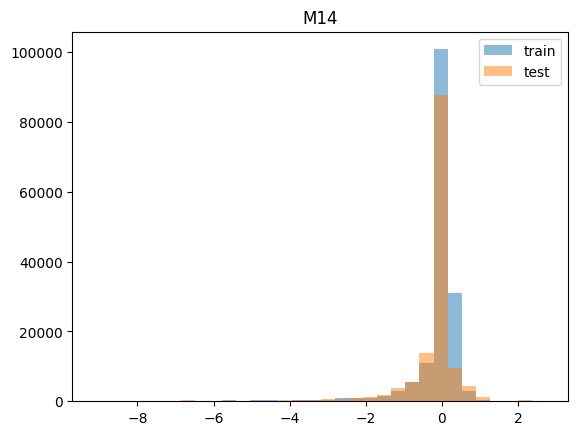

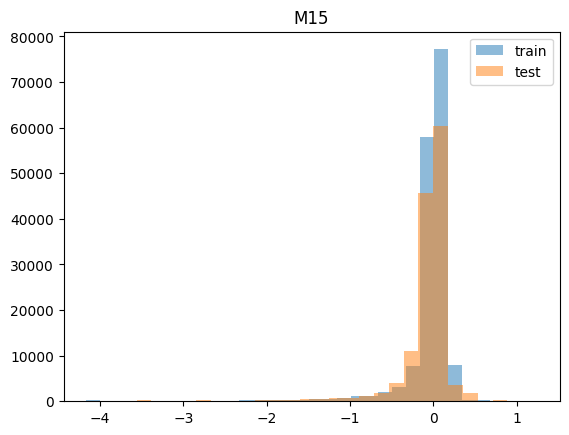

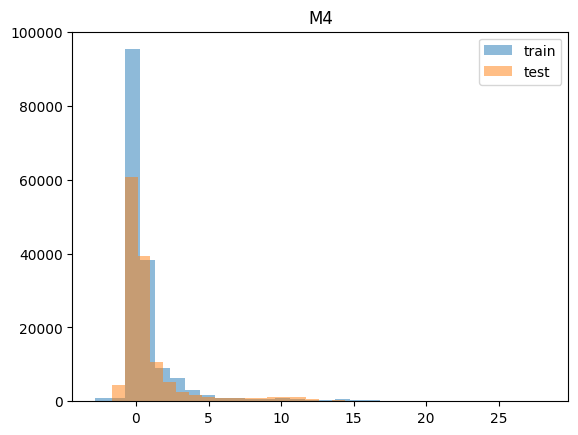

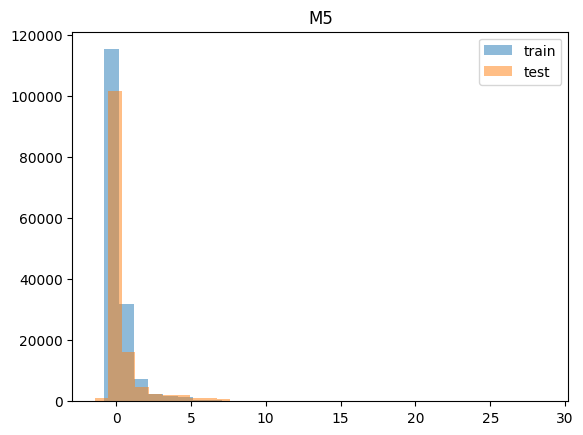

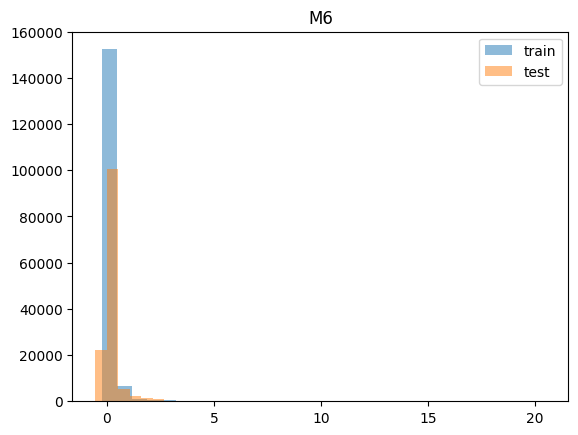

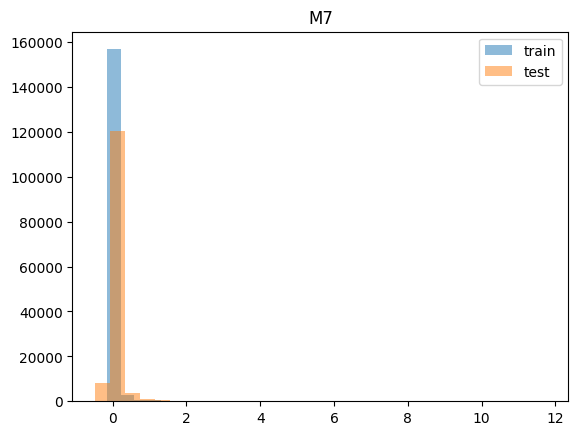

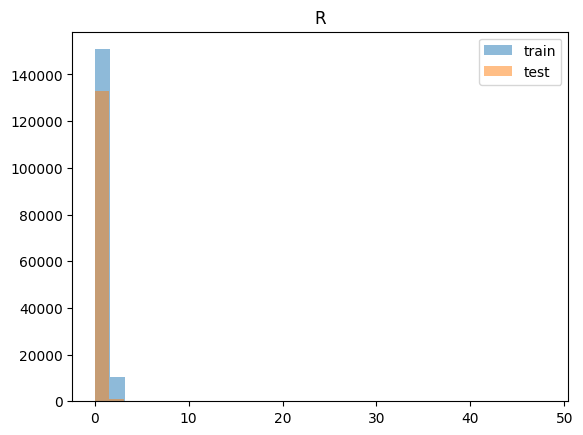

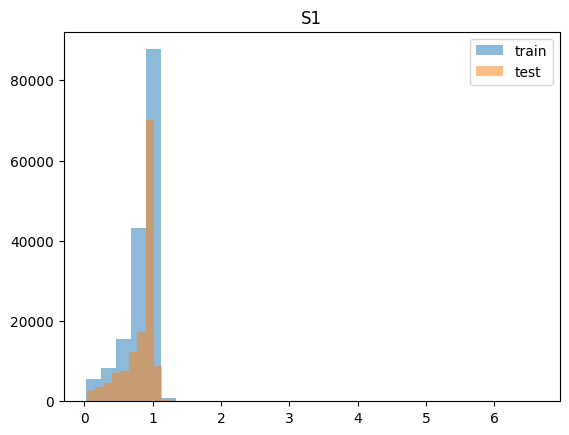

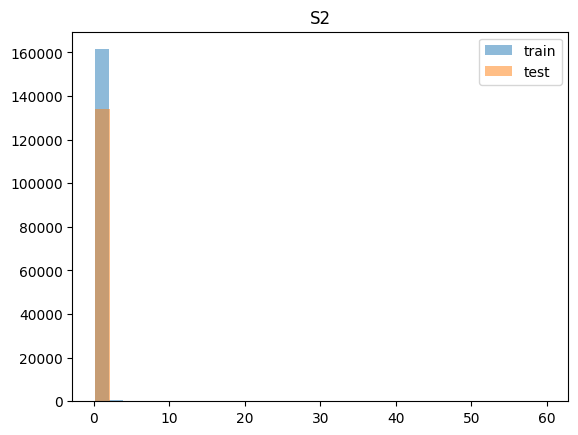

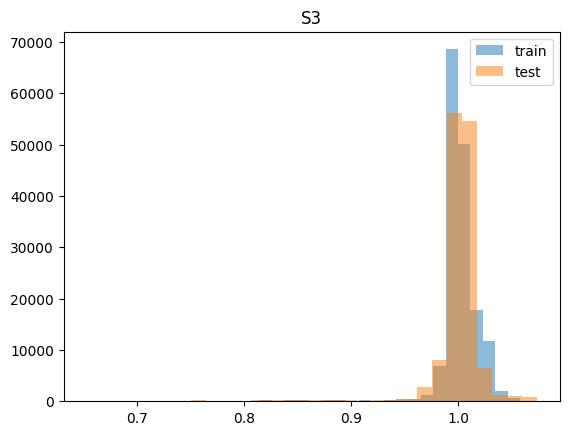

In [27]:
for col in X_train.columns:
    plt.hist(X_train[col], bins=30, alpha=0.5, label="train")
    plt.hist(X_TEST[col], bins=30, alpha=0.5, label="test")
    plt.title(col)
    plt.legend()
    plt.show()

On voit que la distribution de humidité n'est pas la même dans le train et le TEST.

### Importance weighting

In [28]:
def importance_weighting(X_train):
    # On transforme en format numpy
    X_TEST_np = X_TEST.to_numpy()
    # On supprime la première colonne "ID"
    X_TEST_np = np.delete(X_TEST_np, 0, axis=1)
    # On supprime la colonne "Humidity" si drop != None
    if drop != None:
        X_TEST_np = np.delete(X_TEST_np, 0, axis=1)

    # Concaténation verticale (empilement des lignes)
    X_all = np.vstack([X_train, X_TEST_np])
    # Création du label : 0 = train, 1 = test
    y_all = np.concatenate([
        np.zeros(len(X_train), dtype=int),
        np.ones(len(X_TEST_np), dtype=int)
    ])

    # On entraîne un classifieur à dire si un point vient du train (0) ou du test (1)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_all, y_all)

    # Probabilité d'appartenir à X_TEST
    train_probs = clf.predict_proba(X_train)[:, 1]  # P(test | x)
    
    # Poids plus important pour les données du train qui sont proches des données du test
    weights = train_probs / (1 - train_probs + 1e-6)
    
    # clipping pour éviter les poids extrêmes
    weights = np.clip(weights, 0, 10)

    return weights

### Data processing function

In [29]:
def data_processing(X, y=None, train=None):
    X = X.copy()
    X.set_index("ID", inplace=True)

    if drop is not None:
        X.drop("Humidity", axis=1, inplace=True)
        # Not a good idea
        # X.drop(remove_col, axis = 1, inplace=True)
        
    if y is not None:
        y = y.copy()
        y.set_index("ID", inplace=True)

        if train is not None:
            y.drop(remove_target, axis = 1, inplace=True)
            """
            # Not a good idea
            mask = (y != 0).any(axis=1)
            X = X[mask]
            y = y[mask]
            """
        return X, y
    else:
        return X

On supprime les colonnes que l'on peut prédire (sans modèle) du y_train set mais pas du y_val test et du y_test set car elles nous serviront à justifier ou à contredire les observations faites sur le y_train set. Il faut donc créer une fonction qui rajoute les colonnes prédictibles (sans modèle) dans le numpy array des prédictions faites par le modèle.

In [30]:
print(y_train_reduced.columns)

Index(['c01', 'c02', 'c03', 'c05', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13',
       'c14', 'c16', 'c17', 'c18', 'c19', 'c23'],
      dtype='object')


In [31]:
# remove_target = ["c04","c06","c07","c15","c20","c21","c22"]
def reconstruct(y_pred):
    index = [3, 5, 6, 14, 19, 20, 21]
    col = [2, 4, 1, None, 1, 4, 2]
    for i in range(len(remove_target)):
        if remove_target[i] != "c15":
            y_pred = np.insert(y_pred, index[i], y_pred[:,col[i]], axis=1)
        else:
            y_pred = np.insert(y_pred, index[i], np.zeros(len(y_pred[:,0])), axis=1)
    return y_pred

## Data Pre-processing

In [32]:
def pre_processing(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

## Function to plot evaluation results

In [33]:
def plot_results(mse_train, mse_test, mae_train, mae_test):
    plt.figure(figsize=(12, 6))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.plot(mse_train, label="Train MSE", marker='o')
    plt.plot(mse_test, label="Test MSE", marker='o')
    plt.title("MSE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(mae_train, label="Train MAE", marker='o')
    plt.plot(mae_test, label="Test MAE", marker='o')
    plt.title("MAE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Models

In [34]:
def Linear_model(X, y, n_splits = 5):
    fold = KFold(n_splits=n_splits)
    rmse_train = []
    rmse_test = []
    mae_train = []
    mae_test = []

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        X_train, y_train = data_processing(X_train, y_train, train)
        X_test, y_test = data_processing(X_test, y_test)
        X_train , X_test = pre_processing(X_train, X_test)

        # Importance weighting
        weights = importance_weighting(X_train)

        # Training
        mod = LinearRegression()
        mod.fit(X_train, y_train, sample_weight=weights)

        # Predictions
        y_train_pred = mod.predict(X_train)
        y_test_pred = mod.predict(X_test)

        # Clipped predictions
        y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
        y_test_pred_clipped = np.clip(y_test_pred, 0, 1)

        # Reconstruct prediction on the test
        y_test_pred_clipped = reconstruct(y_test_pred_clipped)

        if y_test is not None:
            rmse_train.append(root_mean_squared_error(y_train, y_train_pred_clipped))
            rmse_test.append(root_mean_squared_error(y_test, y_test_pred_clipped))
            mae_train.append(mean_absolute_error(y_train, y_train_pred_clipped))
            mae_test.append(mean_absolute_error(y_test, y_test_pred_clipped))

    if y_test is not None:     
        return y_test_pred, rmse_train, rmse_test, mae_train, mae_test, mod
    else:
        return y_test_pred, mod

In [35]:
def Adaboost(X, y , n_splits = 5, n_estimators = 10, learning_rate = 1.0):
    fold = KFold(n_splits=n_splits)
    rmse_train = []
    rmse_test = []
    mae_train = []
    mae_test = []

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        X_train, y_train = data_processing(X_train, y_train, train)
        X_test, y_test = data_processing(X_test, y_test)
        X_train , X_test = pre_processing(X_train, X_test)

        # Importance weighting
        weights = importance_weighting(X_train)

        # Training
        mod = AdaBoostRegressor(n_estimators = n_estimators, learning_rate = learning_rate, random_state=seed)
        model = MultiOutputRegressor(mod, n_jobs=n_jobs)
        model.fit(X_train, y_train, sample_weight=weights)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Clipped predictions
        y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
        y_test_pred_clipped = np.clip(y_test_pred, 0, 1)

        # Reconstruct prediction on the test
        y_test_pred_clipped = reconstruct(y_test_pred_clipped)

        if y_test is not None:
            rmse_train.append(root_mean_squared_error(y_train, y_train_pred_clipped))
            rmse_test.append(root_mean_squared_error(y_test, y_test_pred_clipped))
            mae_train.append(mean_absolute_error(y_train, y_train_pred_clipped))
            mae_test.append(mean_absolute_error(y_test, y_test_pred_clipped))

    if y_test is not None:     
        return y_test_pred, rmse_train, rmse_test, mae_train, mae_test, model
    else:
        return y_test_pred, model

In [36]:
def Xgboost(X, y , n_splits = 5, max_depth = 5, learning_rate = 1.0, n_estimators = 10):
    fold = KFold(n_splits=n_splits)
    rmse_train = []
    rmse_test = []
    mae_train = []
    mae_test = []

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        X_train, y_train = data_processing(X_train, y_train, train)
        X_test, y_test = data_processing(X_test, y_test)
        X_train , X_test = pre_processing(X_train, X_test)

        # Importance weighting
        weights = importance_weighting(X_train)

        # Training
        mod = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=seed)
        model = MultiOutputRegressor(mod, n_jobs=n_jobs)
        model.fit(X_train, y_train, sample_weight=weights)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Clipped predictions
        y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
        y_test_pred_clipped = np.clip(y_test_pred, 0, 1)

        # Reconstruct prediction on the test
        y_test_pred_clipped = reconstruct(y_test_pred_clipped)

        if y_test is not None:
            rmse_train.append(root_mean_squared_error(y_train, y_train_pred_clipped))
            rmse_test.append(root_mean_squared_error(y_test, y_test_pred_clipped))
            mae_train.append(mean_absolute_error(y_train, y_train_pred_clipped))
            mae_test.append(mean_absolute_error(y_test, y_test_pred_clipped))

    if y_test is not None:     
        return y_test_pred, rmse_train, rmse_test, mae_train, mae_test, model
    else:
        return y_test_pred, model

In [37]:
def RandomForest(X, y , n_splits = 5, max_depth = 7, n_estimators = 5):
    fold = KFold(n_splits=n_splits)
    rmse_train = []
    rmse_test = []
    mae_train = []
    mae_test = []

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        X_train, y_train = data_processing(X_train, y_train, train)
        X_test, y_test = data_processing(X_test, y_test)
        X_train , X_test = pre_processing(X_train, X_test)

        # Importance weighting
        weights = importance_weighting(X_train)

        # Training
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=0.01, 
                                      min_samples_leaf=30, random_state=seed, n_jobs=n_jobs)
        model.fit(X_train, y_train, sample_weight=weights)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Clipped predictions
        y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
        y_test_pred_clipped = np.clip(y_test_pred, 0, 1)

        # Reconstruct prediction on the test
        y_test_pred_clipped = reconstruct(y_test_pred_clipped)

        if y_test is not None:
            rmse_train.append(root_mean_squared_error(y_train, y_train_pred_clipped))
            rmse_test.append(root_mean_squared_error(y_test, y_test_pred_clipped))
            mae_train.append(mean_absolute_error(y_train, y_train_pred_clipped))
            mae_test.append(mean_absolute_error(y_test, y_test_pred_clipped))

    if y_test is not None:     
        return y_test_pred, rmse_train, rmse_test, mae_train, mae_test, model
    else:
        return y_test_pred, model

Linear model

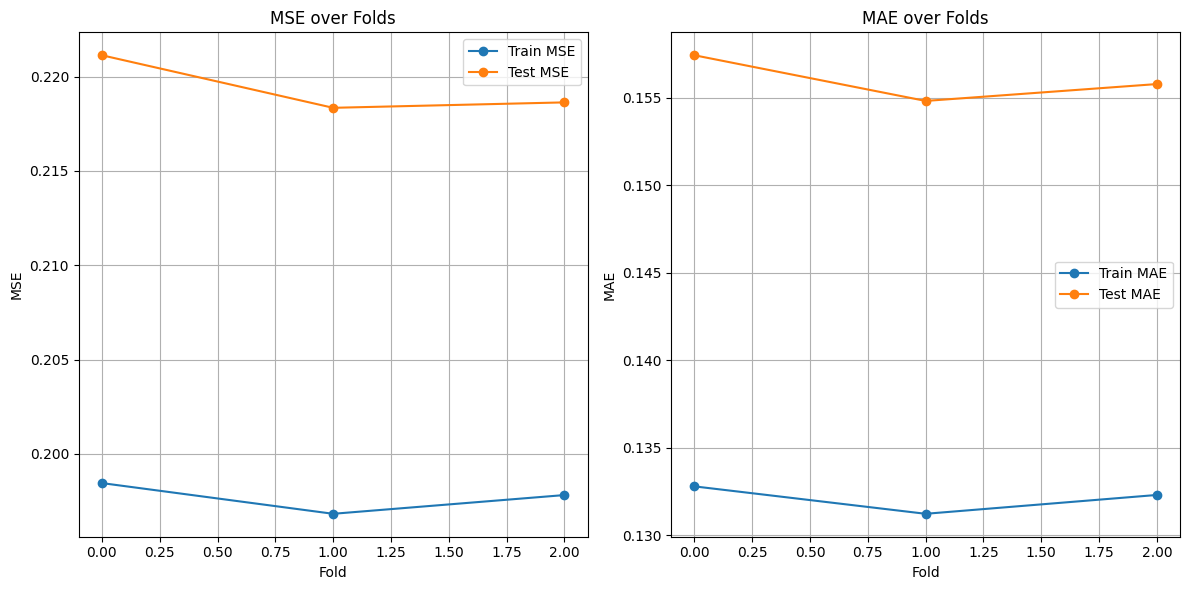

In [38]:
y_test_pred, rmse_train, rmse_test, mae_train, mae_test, mod = Linear_model(X_train, y_train, n_splits)
plot_results(rmse_train, rmse_test, mae_train, mae_test)

In [39]:
print(np.mean(rmse_test),np.mean(mae_test))

0.21936695618136418 0.15601271737820363


Adaboost

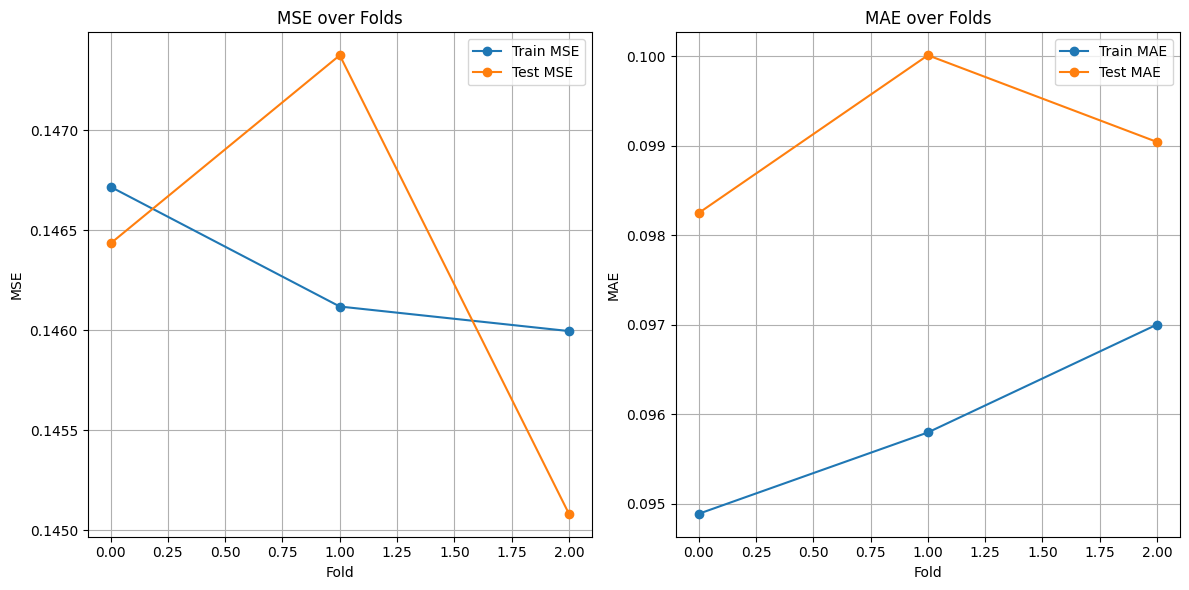

In [40]:
y_test_pred, rmse_train, rmse_test, mae_train, mae_test, mod = Adaboost(X_train, y_train, n_splits)
plot_results(rmse_train, rmse_test, mae_train, mae_test)

In [41]:
print(np.mean(rmse_test),np.mean(mae_test))

0.14629787785305576 0.0991019440290769


Xgboost

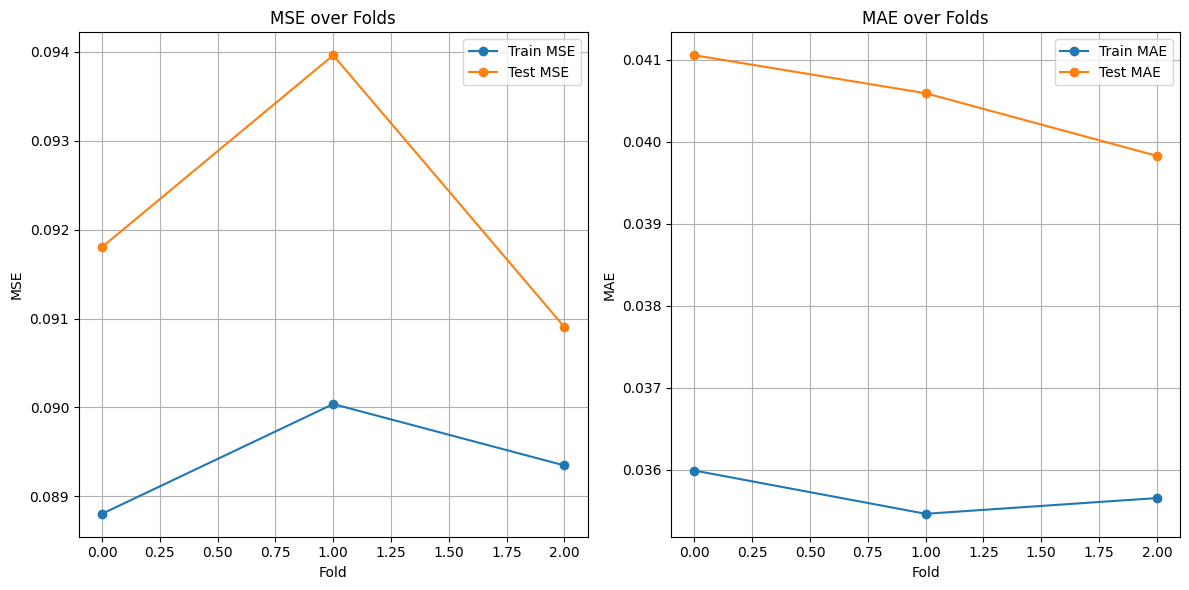

In [42]:
y_test_pred, rmse_train, rmse_test, mae_train, mae_test, mod = Xgboost(X_train, y_train, n_splits)
plot_results(rmse_train, rmse_test, mae_train, mae_test)

In [43]:
print(np.mean(rmse_test),np.mean(mae_test))

0.09222376843293507 0.04049224282304446


Random Forest

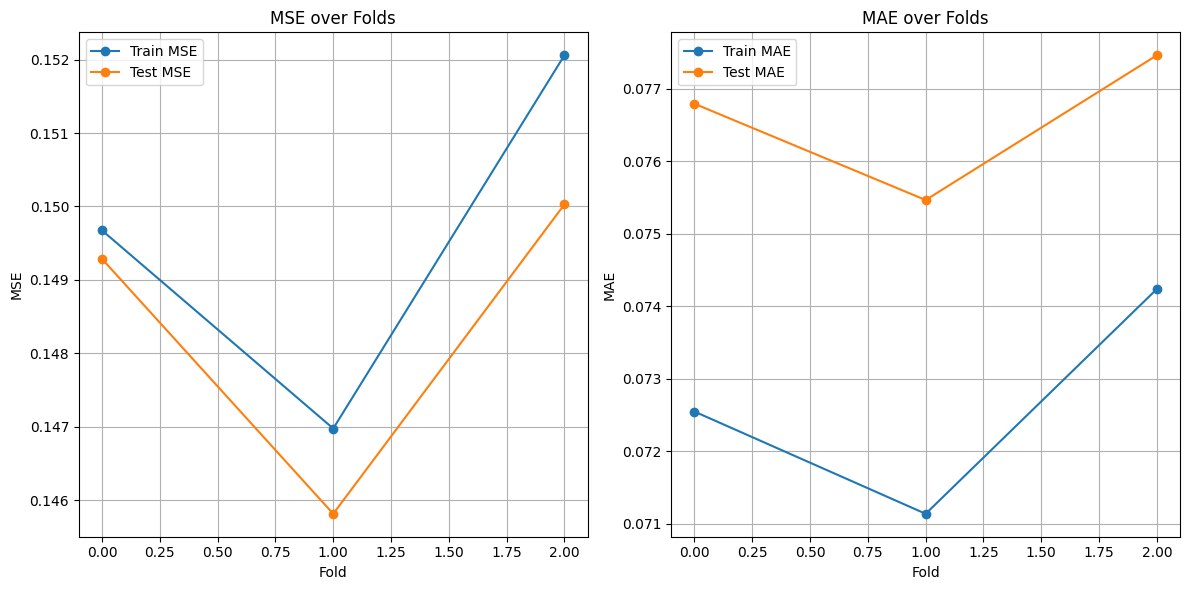

In [44]:
y_test_pred, rmse_train, rmse_test, mae_train, mae_test, mod = RandomForest(X_train, y_train, n_splits)
plot_results(rmse_train, rmse_test, mae_train, mae_test)

In [45]:
print(np.mean(rmse_test),np.mean(mae_test))

0.14837525881602187 0.07657211379017455


We observe that the RMSE is larger than the MAE.

## Calibration of hyper-parameters

Adaboost

In [46]:
# Define parameter combinations to test
param_grid = {
    'n_estimators': [15],
    'learning_rate': [1.0]
}
# base_estimator = DecisionTreeRegressor(max_depth=3)


best_mean_score = np.inf
best_mean_params = None
best_mean_model = None


# Total number of combinations
total = len(param_grid["n_estimators"]) * len(param_grid["learning_rate"])

# Manual buckle
with tqdm(total=total, desc="Grid search") as pbar:
    for estimator in param_grid["n_estimators"]:
        for lr in param_grid["learning_rate"]:
            print(f"⏳ Test with n_estimators={estimator}, learning_rate={lr}")
            
            rmse_train = []
            rmse_val = []
            mae_train = []
            mae_val = []
            metric_value_train = []
            metric_value_val = []

            y_vals = []
            y_vals_pred = []

            fold = KFold(n_splits=n_splits)
            for train_index, test_index in fold.split(X_train, y_train):
                X_train_train, X_train_val = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
                y_train_train, y_train_val = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()

                X_train_train, y_train_train = data_processing(X_train_train, y_train_train, train)
                X_train_val, y_train_val = data_processing(X_train_val, y_train_val)
                X_train_train , X_train_val = pre_processing(X_train_train, X_train_val)

                # Importance weighting
                weights = importance_weighting(X_train_train)
        
                # Create the model
                ada = MultiOutputRegressor(
                    AdaBoostRegressor(
                    # base_estimator=base_estimator,
                    n_estimators=estimator,
                    learning_rate=lr,
                    random_state=seed
                    ),
                    n_jobs=n_jobs
                )
        
                # Training
                ada.fit(X_train_train, y_train_train, sample_weight=weights)

                # Predictions
                y_train_pred = ada.predict(X_train_train)
                y_train_val_pred = ada.predict(X_train_val)

                # Clipped predictions
                y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
                y_train_val_pred_clipped = np.clip(y_train_val_pred, 0, 1)

                # Reconstruct prediction on the validation
                y_train_val_pred_clipped = reconstruct(y_train_val_pred_clipped)

                # Evaluation
                rmse_train.append(root_mean_squared_error(y_train_train, y_train_pred_clipped))
                rmse_val.append(root_mean_squared_error(y_train_val, y_train_val_pred_clipped))
                mae_train.append(mean_absolute_error(y_train_train, y_train_pred_clipped))
                mae_val.append(mean_absolute_error(y_train_val, y_train_val_pred_clipped))
                metric_value_train.append(metric(y_train_train, y_train_pred_clipped))
                metric_value_val.append(metric(y_train_val, y_train_val_pred_clipped))

                # Keep the predictions
                y_vals.append(y_train_val)
                y_vals_pred.append(y_train_val_pred)


            mean_rmse_train = np.mean(rmse_train)
            mean_rmse_val = np.mean(rmse_val)
            mean_mae_train = np.mean(mae_train)
            mean_mae_val = np.mean(mae_val)
            mean_metric_value_train = np.mean(metric_value_train)
            mean_metric_value_val = np.mean(metric_value_val)

            print(f"➡️ Mean RMSE on the train: {mean_rmse_train:.4f}")
            print(f"➡️ Mean RMSE on the validation: {mean_rmse_val:.4f}")
            print(f"➡️ Mean MAE on the train: {mean_mae_train:.4f}")
            print(f"➡️ Mean MAE on the validation: {mean_mae_val:.4f}")
            print(f"➡️ Mean metric value on the train: {mean_metric_value_train:.4f}")
            print(f"➡️ Mean metric value on the validation: {mean_metric_value_val:.4f}")
            print("-"*50)
        
            # Save the best
            if mean_metric_value_val < best_mean_score:
                best_mean_score = mean_metric_value_val
                best_mean_params = {"n_estimators": estimator, "learning_rate": lr}
                y_val_best = y_vals
                y_val_pred_best = y_vals_pred
            
            # Move the bar forward
            pbar.update(1)

print("✅ Best parameters :", best_mean_params)
print("✅ Best score :", best_mean_score)

Grid search:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Test with n_estimators=15, learning_rate=1.0


Grid search: 100%|██████████| 1/1 [01:11<00:00, 71.26s/it]

➡️ Mean RMSE on the train: 0.1473
➡️ Mean RMSE on the validation: 0.1467
➡️ Mean MAE on the train: 0.1016
➡️ Mean MAE on the validation: 0.1041
➡️ Mean metric value on the train: 0.1660
➡️ Mean metric value on the validation: 0.1682
--------------------------------------------------
✅ Best parameters : {'n_estimators': 15, 'learning_rate': 1.0}
✅ Best score : 0.1682426053142667


✅ Best parameters : {'n_estimators': 9, 'learning_rate': 0.85}
✅ Best score : 0.12985956624858694

Xgboost

In [47]:
"""
# Define parameter combinations to test
param_grid = {
    'max_depth': [5],
    'n_estimators': [20],
    'learning_rate': [0.5, 0.75, 1.0]
}


best_mean_score = np.inf
best_mean_params = None
best_mean_model = None


# Total number of combinations
total = len(param_grid["max_depth"]) * len(param_grid["n_estimators"]) * len(param_grid["learning_rate"])

# Manual buckle
with tqdm(total=total, desc="Grid search") as pbar:
    for depth in param_grid["max_depth"]:
        for estimator in param_grid["n_estimators"]:
            for lr in param_grid["learning_rate"]:
                print(f"⏳ Test with max_depth={depth}, n_estimators={estimator}, learning_rate={lr}")
            
                rmse_train = []
                rmse_val = []
                mae_train = []
                mae_val = []
                metric_value_train = []
                metric_value_val = []

                y_vals = []
                y_vals_pred = []

                fold = KFold(n_splits=n_splits)
                for train_index, test_index in fold.split(X_train, y_train):
                    X_train_train, X_train_val = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
                    y_train_train, y_train_val = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()

                    X_train_train, y_train_train = data_processing(X_train_train, y_train_train, train)
                    X_train_val, y_train_val = data_processing(X_train_val, y_train_val)
                    X_train_train , X_train_val = pre_processing(X_train_train, X_train_val)

                    # Importance weighting
                    weights = importance_weighting(X_train_train)
        
                    # Create the model
                    xg = MultiOutputRegressor(
                        XGBRegressor(
                        max_depth = depth,
                        learning_rate=lr,
                        n_estimators=estimator,
                        random_state=seed
                        ),
                        n_jobs=n_jobs
                    )
        
                    # Training
                    xg.fit(X_train_train, y_train_train, sample_weight=weights)

                    # Predictions
                    y_train_pred = xg.predict(X_train_train)
                    y_train_val_pred = xg.predict(X_train_val)

                    # Clipped predictions
                    y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
                    y_train_val_pred_clipped = np.clip(y_train_val_pred, 0, 1)

                    # Reconstruct prediction on the validation
                    y_train_val_pred_clipped = reconstruct(y_train_val_pred_clipped)

                    # Evaluation
                    rmse_train.append(root_mean_squared_error(y_train_train, y_train_pred_clipped))
                    rmse_val.append(root_mean_squared_error(y_train_val, y_train_val_pred_clipped))
                    mae_train.append(mean_absolute_error(y_train_train, y_train_pred_clipped))
                    mae_val.append(mean_absolute_error(y_train_val, y_train_val_pred_clipped))
                    metric_value_train.append(metric(y_train_train, y_train_pred_clipped))
                    metric_value_val.append(metric(y_train_val, y_train_val_pred_clipped))

                    # Keep the predictions
                    y_vals.append(y_train_val)
                    y_vals_pred.append(y_train_val_pred)


                mean_rmse_train = np.mean(rmse_train)
                mean_rmse_val = np.mean(rmse_val)
                mean_mae_train = np.mean(mae_train)
                mean_mae_val = np.mean(mae_val)
                mean_metric_value_train = np.mean(metric_value_train)
                mean_metric_value_val = np.mean(metric_value_val)

                print(f"➡️ Mean RMSE on the train: {mean_rmse_train:.4f}")
                print(f"➡️ Mean RMSE on the validation: {mean_rmse_val:.4f}")
                print(f"➡️ Mean MAE on the train: {mean_mae_train:.4f}")
                print(f"➡️ Mean MAE on the validation: {mean_mae_val:.4f}")
                print(f"➡️ Mean metric value on the train: {mean_metric_value_train:.4f}")
                print(f"➡️ Mean metric value on the validation: {mean_metric_value_val:.4f}")
                print("-"*50)
        
                # Save the best
                if mean_metric_value_val < best_mean_score:
                    best_mean_score = mean_metric_value_val
                    best_mean_params = {"max_depth": depth, "learning_rate": lr, "n_estimators": estimator}
                    y_val_best = y_vals
                    y_val_pred_best = y_vals_pred
            
                # Move the bar forward
                pbar.update(1)

print("✅ Best parameters :", best_mean_params)
print("✅ Best score :", best_mean_score)
"""

'\n# Define parameter combinations to test\nparam_grid = {\n    \'max_depth\': [5],\n    \'n_estimators\': [20],\n    \'learning_rate\': [0.5, 0.75, 1.0]\n}\n\n\nbest_mean_score = np.inf\nbest_mean_params = None\nbest_mean_model = None\n\n\n# Total number of combinations\ntotal = len(param_grid["max_depth"]) * len(param_grid["n_estimators"]) * len(param_grid["learning_rate"])\n\n# Manual buckle\nwith tqdm(total=total, desc="Grid search") as pbar:\n    for depth in param_grid["max_depth"]:\n        for estimator in param_grid["n_estimators"]:\n            for lr in param_grid["learning_rate"]:\n                print(f"⏳ Test with max_depth={depth}, n_estimators={estimator}, learning_rate={lr}")\n\n                rmse_train = []\n                rmse_val = []\n                mae_train = []\n                mae_val = []\n                metric_value_train = []\n                metric_value_val = []\n\n                y_vals = []\n                y_vals_pred = []\n\n                fold 

✅ Best parameters : {'max_depth': 15, 'learning_rate': 0.2, 'n_estimators': 50}
✅ Best score : 0.015407078172257007

Random Forest

In [48]:
# Define parameter combinations to test
param_grid = {
    'max_depth': [10],
    'n_estimators': [10],
    'min_samples_split': [0.01],
}


best_mean_score = np.inf
best_mean_params = None
best_mean_model = None


# Total number of combinations
total = len(param_grid["max_depth"]) * len(param_grid["n_estimators"]) * len(param_grid["min_samples_split"])

# Manual buckle
with tqdm(total=total, desc="Grid search") as pbar:
    for depth in param_grid["max_depth"]:
        for estimator in param_grid["n_estimators"]:
            for split in param_grid["min_samples_split"]:
                print(f"⏳ Test with max_depth={depth}, n_estimators={estimator}, min_samples_split={split}")
            
                rmse_train = []
                rmse_val = []
                mae_train = []
                mae_val = []
                metric_value_train = []
                metric_value_val = []

                y_vals = []
                y_vals_pred = []

                fold = KFold(n_splits=n_splits)
                for train_index, test_index in fold.split(X_train, y_train):
                    X_train_train, X_train_val = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
                    y_train_train, y_train_val = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()

                    X_train_train, y_train_train = data_processing(X_train_train, y_train_train, train)
                    X_train_val, y_train_val = data_processing(X_train_val, y_train_val)
                    X_train_train , X_train_val = pre_processing(X_train_train, X_train_val)

                    # Importance weighting
                    weights = importance_weighting(X_train_train)
        
                    # Create the model
                    rf = RandomForestRegressor(
                        max_depth = depth,
                        n_estimators=estimator,
                        min_samples_split=split,
                        min_samples_leaf=30,
                        criterion="squared_error",
                        random_state=seed,
                        n_jobs=n_jobs
                        )
        
                    # Training
                    rf.fit(X_train_train, y_train_train, sample_weight=weights)

                    # Predictions
                    y_train_pred = rf.predict(X_train_train)
                    y_train_val_pred = rf.predict(X_train_val)

                    # Clipped predictions
                    y_train_pred_clipped = np.clip(y_train_pred, 0, 1)
                    y_train_val_pred_clipped = np.clip(y_train_val_pred, 0, 1)

                    # Reconstruct prediction on the validation
                    y_train_val_pred_clipped = reconstruct(y_train_val_pred_clipped)

                    # Evaluation
                    rmse_train.append(root_mean_squared_error(y_train_train, y_train_pred_clipped))
                    rmse_val.append(root_mean_squared_error(y_train_val, y_train_val_pred_clipped))
                    mae_train.append(mean_absolute_error(y_train_train, y_train_pred_clipped))
                    mae_val.append(mean_absolute_error(y_train_val, y_train_val_pred_clipped))
                    metric_value_train.append(metric(y_train_train, y_train_pred_clipped))
                    metric_value_val.append(metric(y_train_val, y_train_val_pred_clipped))

                    # Keep the predictions
                    y_vals.append(y_train_val)
                    y_vals_pred.append(y_train_val_pred)


                mean_rmse_train = np.mean(rmse_train)
                mean_rmse_val = np.mean(rmse_val)
                mean_mae_train = np.mean(mae_train)
                mean_mae_val = np.mean(mae_val)
                mean_metric_value_train = np.mean(metric_value_train)
                mean_metric_value_val = np.mean(metric_value_val)

                print(f"➡️ Mean RMSE on the train: {mean_rmse_train:.4f}")
                print(f"➡️ Mean RMSE on the validation: {mean_rmse_val:.4f}")
                print(f"➡️ Mean MAE on the train: {mean_mae_train:.4f}")
                print(f"➡️ Mean MAE on the validation: {mean_mae_val:.4f}")
                print(f"➡️ Mean metric value on the train: {mean_metric_value_train:.4f}")
                print(f"➡️ Mean metric value on the validation: {mean_metric_value_val:.4f}")
                print("-"*50)
        
                # Save the best
                if mean_metric_value_val < best_mean_score:
                    best_mean_score = mean_metric_value_val
                    best_mean_params = {"max_depth": depth, "n_estimators": estimator, "min_samples_split": split}
                    y_val_best = y_vals
                    y_val_pred_best = y_vals_pred
            
                # Move the bar forward
                pbar.update(1)

print("✅ Best parameters :", best_mean_params)
print("✅ Best score :", best_mean_score)


Grid search:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Test with max_depth=10, n_estimators=10, min_samples_split=0.01


Grid search: 100%|██████████| 1/1 [00:18<00:00, 18.50s/it]

➡️ Mean RMSE on the train: 0.1213
➡️ Mean RMSE on the validation: 0.1220
➡️ Mean MAE on the train: 0.0505
➡️ Mean MAE on the validation: 0.0551
➡️ Mean metric value on the train: 0.1371
➡️ Mean metric value on the validation: 0.1409
--------------------------------------------------
✅ Best parameters : {'max_depth': 10, 'n_estimators': 10, 'min_samples_split': 0.01}
✅ Best score : 0.14089738473418434


### Modification of the prediction of the best model 

In [49]:
print(len(y_val_pred_best))
print(len(y_val_pred_best[0]))
print(len(y_val_pred_best[0][0]))
print(len(y_val_best))
print(y_val_best[0].shape)

3
54116
16
3
(54116, 23)


y_val_best = [3 * pandas(n, 23)] and y_val_pred_best = [3 * [n * [ (16) ] ] ]

In [50]:
alphas = [0.5, 0.6, 0.8, 1.0] 
thresholds = [0.2, 0.3, 0.4, 0.5] 
floors = [0.5, 0.65, 0.7, 0.75, 0.8] 

best_mean_score_modif = best_mean_score
best_mean_params_metric = {}


for alpha in alphas:
    for threshold in thresholds:
        for floor in floors:
            scores = []
            for i in range(len(y_val_best)):
                y_pp = modif_predictions(y_val_pred_best[i], alpha, threshold, floor)
                y_pp = reconstruct(y_pp)
                scores.append(metric(y_val_best[i], y_pp))
                
            score = np.mean(scores)
            if score < best_mean_score_modif:
                best_mean_score_modif = score
                best_mean_params_metric = {"alpha": alpha, "threshold": threshold, "floor": floor}

print("✅ Best mean combination :", best_mean_params_metric)
print("✅ Best mean score :", best_mean_score_modif)

# Best mean combination : {'alpha': 0.95, 'threshold': 0.45, 'floor': 0.75}
# Best mean score : : 0.12668979799195573


✅ Best mean combination : {}
✅ Best mean score : 0.14089738473418434


In [51]:
if best_mean_params_metric != {}:
    alpha = best_mean_params_metric["alpha"]
    threshold = best_mean_params_metric["threshold"]
    floor = best_mean_params_metric["floor"]
    print(alpha, threshold, floor)

## Evaluation of the best model on the test

In [52]:
depth = best_mean_params["max_depth"]
estimator = best_mean_params["n_estimators"]
split = best_mean_params["min_samples_split"]
# lr = best_mean_params["learning_rate"]
# print(depth, estimator, lr)
# print(estimator, lr)
print(depth, estimator, split)

10 10 0.01


In [53]:
def best_model_prediction(X_train, y_train, X_test, y_test):
    depth = best_mean_params["max_depth"]
    estimator = best_mean_params["n_estimators"]
    # lr = best_mean_params["learning_rate"]
    split = best_mean_params["min_samples_split"]

    best_model = RandomForestRegressor(
                        max_depth = depth,
                        n_estimators=estimator,
                        min_samples_split=split,
                        min_samples_leaf=30,
                        criterion="squared_error",
                        random_state=seed,
                        n_jobs=n_jobs
                        )

    X_train, y_train = data_processing(X_train, y_train, train)

    if y_test is not None:
        X_test, y_test = data_processing(X_test, y_test)
    else:
        X_test = data_processing(X_test, y_test)
        
    X_train , X_test = pre_processing(X_train, X_test)

    # Importance weighting
    weights = importance_weighting(X_train)

    best_model.fit(X_train, y_train, sample_weight=weights)

    y_test_pred = best_model.predict(X_test)

    return y_test, y_test_pred

In [54]:
y_test, y_test_pred = best_model_prediction(X_train, y_train, X_test, y_test)
y_test_pred = reconstruct(y_test_pred)
y_test_pred_clipped = np.clip(y_test_pred, 0, 1)
# y_test_pred_modif = modif_predictions(y_test_pred, alpha, threshold, floor)

In [55]:
score_clipped = metric(y_test, y_test_pred_clipped)
# score_modif = metric(y_test, y_test_pred_modif)
print(score_clipped)
# print(score_modif)
# print(score_modif < score_clipped)
"""
0.12975213179227912
0.12701467828278773
True
"""

0.1367706717013898


'\n0.12975213179227912\n0.12701467828278773\nTrue\n'

## Generating Submission File

In [56]:
X_TEST = pd.read_csv("x_test_9F13O5s.csv", sep=",")
print(X_TEST.shape)
print(X_TEST.head())


(134673, 14)
       ID  Humidity       M12       M13       M14       M15        M4  \
0  202933  0.869916  0.021914 -0.015737  0.009041  0.015662 -0.139344   
1  202934  0.904594 -0.100771 -0.040901  0.006137  0.013496  0.843534   
2  202935  0.688853  0.703585  1.029723  0.785505  0.293766 -0.536002   
3  202936  0.392112  0.648665  0.628007  0.416822  0.065360 -0.309533   
4  202937  0.618233  0.155158  0.285085  0.081453  0.031029 -0.801587   

         M5        M6        M7         R        S1        S2        S3  
0 -0.041396 -0.006051  0.001638  1.008217  1.000922  1.003093  0.998643  
1  0.501194  0.134963  0.024947  1.010621  0.987593  1.003104  1.009033  
2 -0.166262 -0.029509 -0.015855  1.075560  1.015945  1.038617  1.067383  
3 -0.398324 -0.269763 -0.269454  1.160165  1.084636  1.011883  1.008619  
4 -0.709802 -0.279257 -0.089210  1.051850  1.120134  1.003001  1.007571  


### Create the model on all data

In [60]:
y_TEST, y_TEST_pred = best_model_prediction(X, y, X_TEST, y_test=None)
y_TEST_pred = reconstruct(y_TEST_pred)
y_TEST_pred_clipped = np.clip(y_TEST_pred, 0, 1)
# y_TEST_pred_modif = modif_predictions(y_TEST_pred, alpha, threshold, floor)
# m, n = y_TEST_pred_modif.shape
m, n = y_TEST_pred_clipped.shape
# print(m,n)

### Creating submission file

In [61]:
columns = ["ID"] + list(y_test.columns)
print(columns)
print(len(columns))
C0 = np.array([i + 202933 for i in range(0,m)])
C0 = C0.reshape(-1, 1)
# y_TEST_pred_new = np.hstack((C0, y_TEST_pred_modif))
y_TEST_pred_new = np.hstack((C0, y_TEST_pred_clipped))
print(y_TEST_pred_new.shape)

['ID', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23']
24
(134673, 24)


In [62]:
submission = pd.DataFrame(y_TEST_pred_new, columns=columns)
submission["ID"] = submission["ID"].astype(int)

submission.to_csv('submission.csv', index=False, sep=',')
print(submission.shape)
print(submission.head())

(134673, 24)
       ID       c01       c02       c03       c04       c05       c06  \
0  202933  0.093149  0.024659  0.139484  0.139484  0.000023  0.000023   
1  202934  0.046125  0.000324  0.313226  0.313226  0.000005  0.000005   
2  202935  0.000000  0.000000  0.151367  0.151367  0.151367  0.151367   
3  202936  0.013484  0.000328  0.528809  0.528809  0.502135  0.502135   
4  202937  0.119772  0.002533  0.158097  0.158097  0.000225  0.000225   

        c07           c08       c09  ...       c14  c15       c16       c17  \
0  0.024659  8.693246e-06  0.000231  ...  0.086308  0.0  0.001345  0.000291   
1  0.000324  2.737475e-05  0.002093  ...  0.045369  0.0  0.000685  0.000612   
2  0.000000  0.000000e+00  0.000000  ...  0.000000  0.0  0.000000  0.000000   
3  0.000328  1.730393e-07  0.000000  ...  0.011652  0.0  0.000000  0.010744   
4  0.002533  3.276783e-06  0.000000  ...  0.104324  0.0  0.000000  0.000022   

        c18       c19       c20       c21       c22       c23  
0  0.0010